#### This is our Resnet 50 architecture + custom layers (v2) as mentioned in the results section of the project report

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# Setting the comet variables for the project
comet_api_key =  os.getenv("COMET_API_KEY")
comet_project_name = os.getenv("COMET_PROJECT_NAME")
comet_workspace_name = os.getenv("COMET_WORKSPACE_NAME")

In [ ]:
# Integrating comet to track results
from comet_ml import Experiment
experiment = Experiment(
  api_key=comet_api_key,
  project_name=comet_project_name,
  workspace=comet_workspace_name,
  auto_metric_logging=True,
  auto_param_logging=True,
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
  auto_histogram_epoch_rate=True,
  log_code=True
)

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2 as ResNet # Resnet50v2 is computationally more efficient and stable than Resnet
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# we are apply data augmentation techniques to help the model generalize better
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)



valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

train_dataset  = train_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
base_model_1 = ResNet(include_top=False, weights='imagenet', input_shape=(48, 48, 3))

for layer in base_model_1.layers[:170]:
    layer.trainable = False

for layer in base_model_1.layers[170:]:
    layer.trainable = True


x = base_model_1.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)


predictions = Dense(7, activation='softmax')(x)
model_1 = Model(inputs=base_model_1.input, outputs=predictions)


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model_1.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

In [5]:
with tf.device('/GPU:0'):
    result_2 = model_1.fit(train_dataset, epochs=122, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/122
359/359 [==============================] - 756s 2s/step - loss: 1.7297 - accuracy: 0.3079 - precision: 0.5281 - recall: 0.0483 - auc: 0.7055 - val_loss: 1.6829 - val_accuracy: 0.3411 - val_precision: 0.5301 - val_recall: 0.1289 - val_auc: 0.7330
Epoch 2/122
359/359 [==============================] - 443s 1s/step - loss: 1.6517 - accuracy: 0.3485 - precision: 0.5962 - recall: 0.0838 - auc: 0.7419 - val_loss: 1.6316 - val_accuracy: 0.3552 - val_precision: 0.5475 - val_recall: 0.1284 - val_auc: 0.7498
Epoch 3/122
359/359 [==============================] - 111s 309ms/step - loss: 1.6196 - accuracy: 0.3652 - precision: 0.6028 - recall: 0.0989 - auc: 0.7554 - val_loss: 1.5785 - val_accuracy: 0.3867 - val_precision: 0.7008 - val_recall: 0.1097 - val_auc: 0.7709
Epoch 4/122
359/359 [==============================] - 103s 287ms/step - loss: 1.5969 - accuracy: 0.3723 - precision: 0.6264 - recall: 0.1119 - auc: 0.7646 - val_loss: 1.5663 - val_accuracy: 0.3897 - val_precision: 0.6858 -

In [17]:
result_2.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])

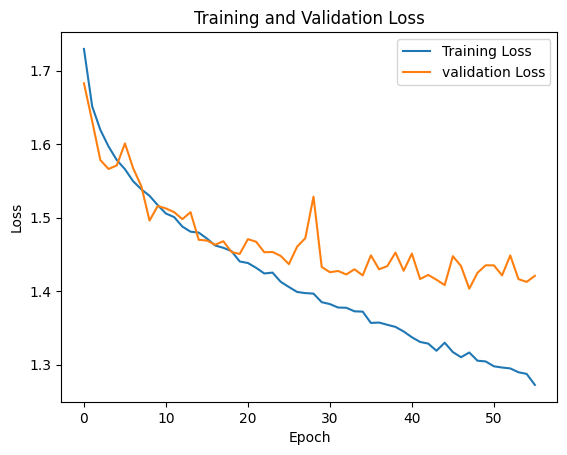

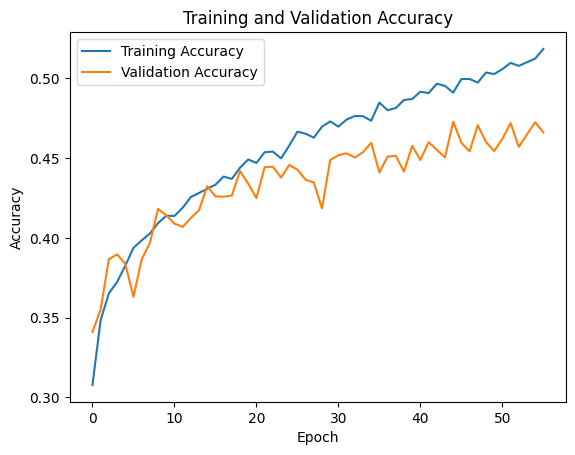

In [18]:
def plot_graph(result):
    # Models Loss graph
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Models accuracy graph
    plt.plot(result.history['accuracy'], label='Training Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_graph(result_2)

In [6]:
model_1.save('resnet_v2.h5')

In [20]:
images, labels = next(test_dataset)

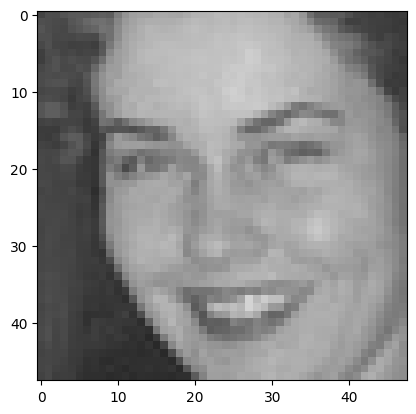

In [21]:
plt.imshow(images[3])

In [22]:
# printing the indexes of classes
class_indexes = train_dataset.class_indices
class_indexes

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [23]:
def compute_label(label_array, class_indexes):
    predicted_class_index = np.argmax(label_array)
    predicted_class = list(class_indexes.keys())[predicted_class_index]
    return predicted_class

### Predicting using the model trained

1/1 [==============================] - 0s 115ms/step


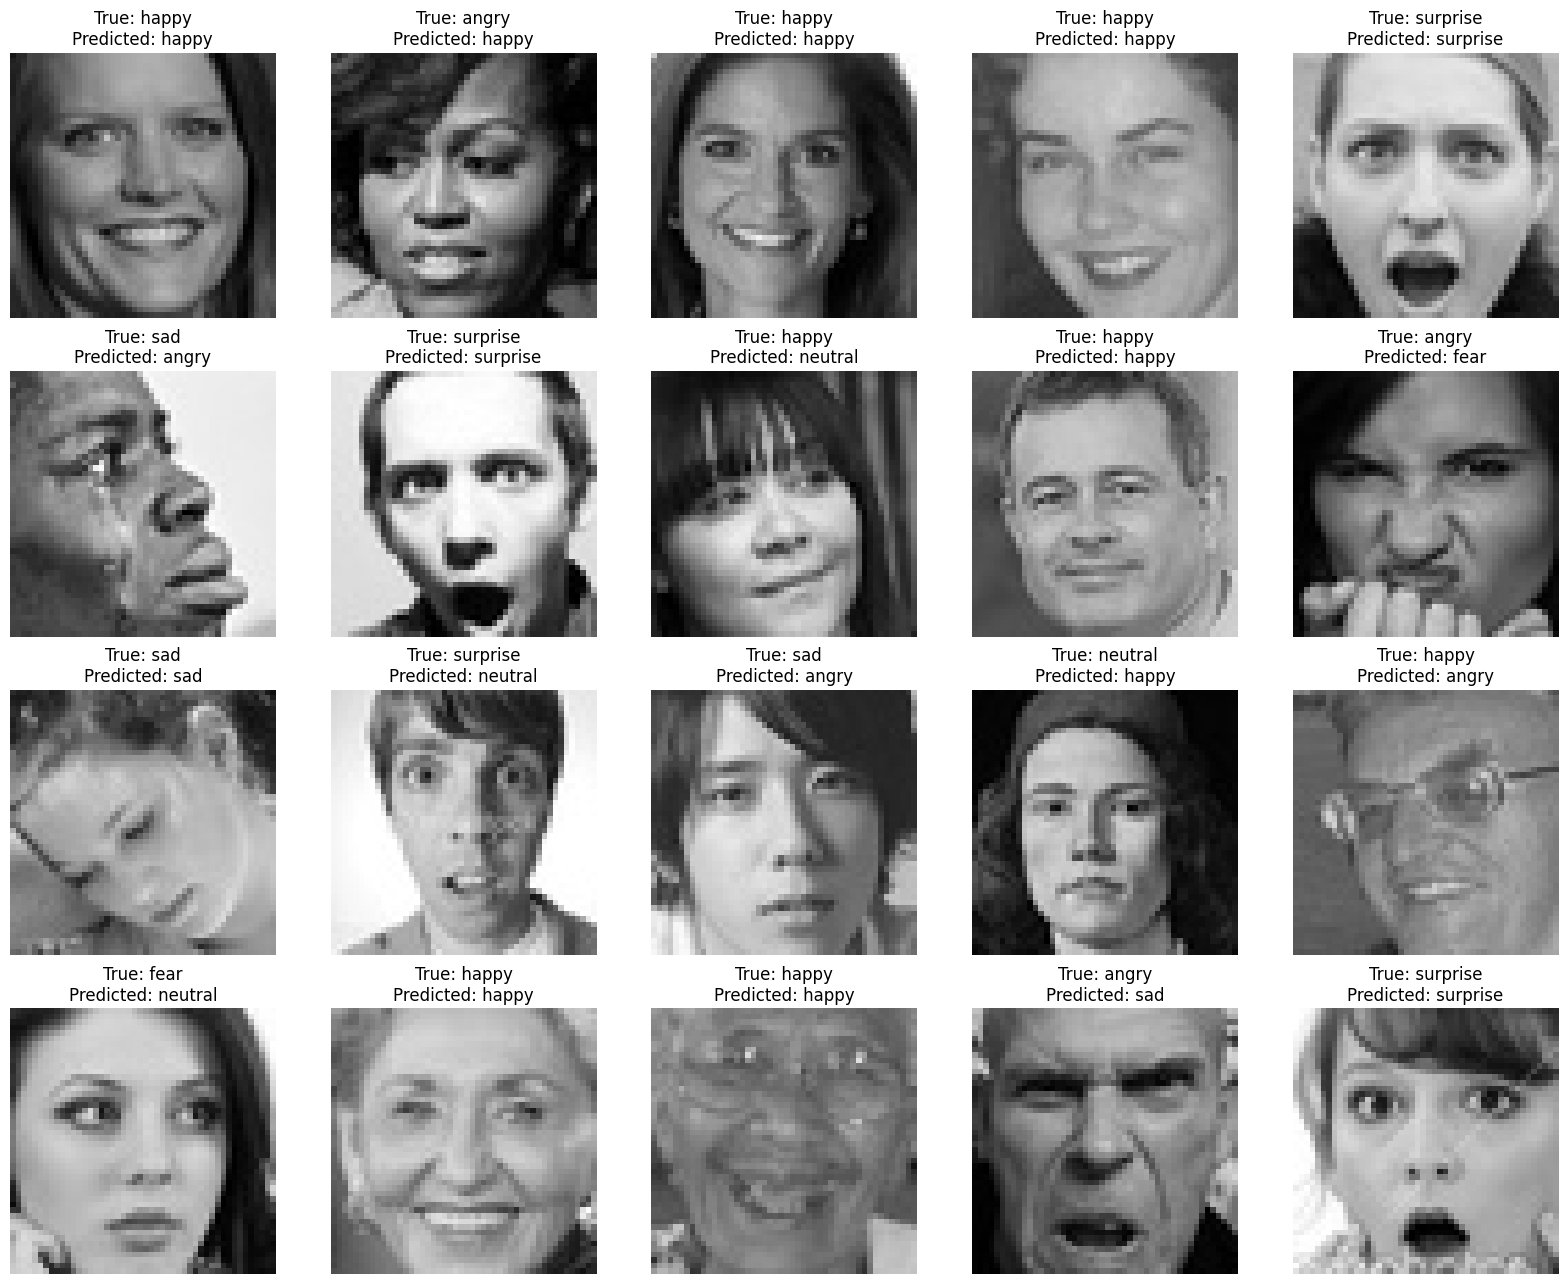

In [24]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(labels[i], class_indexes)
    predicted_label = compute_label(model_1.predict(images[i].reshape((1, 48, 48, 3))), class_indexes)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 77ms/step


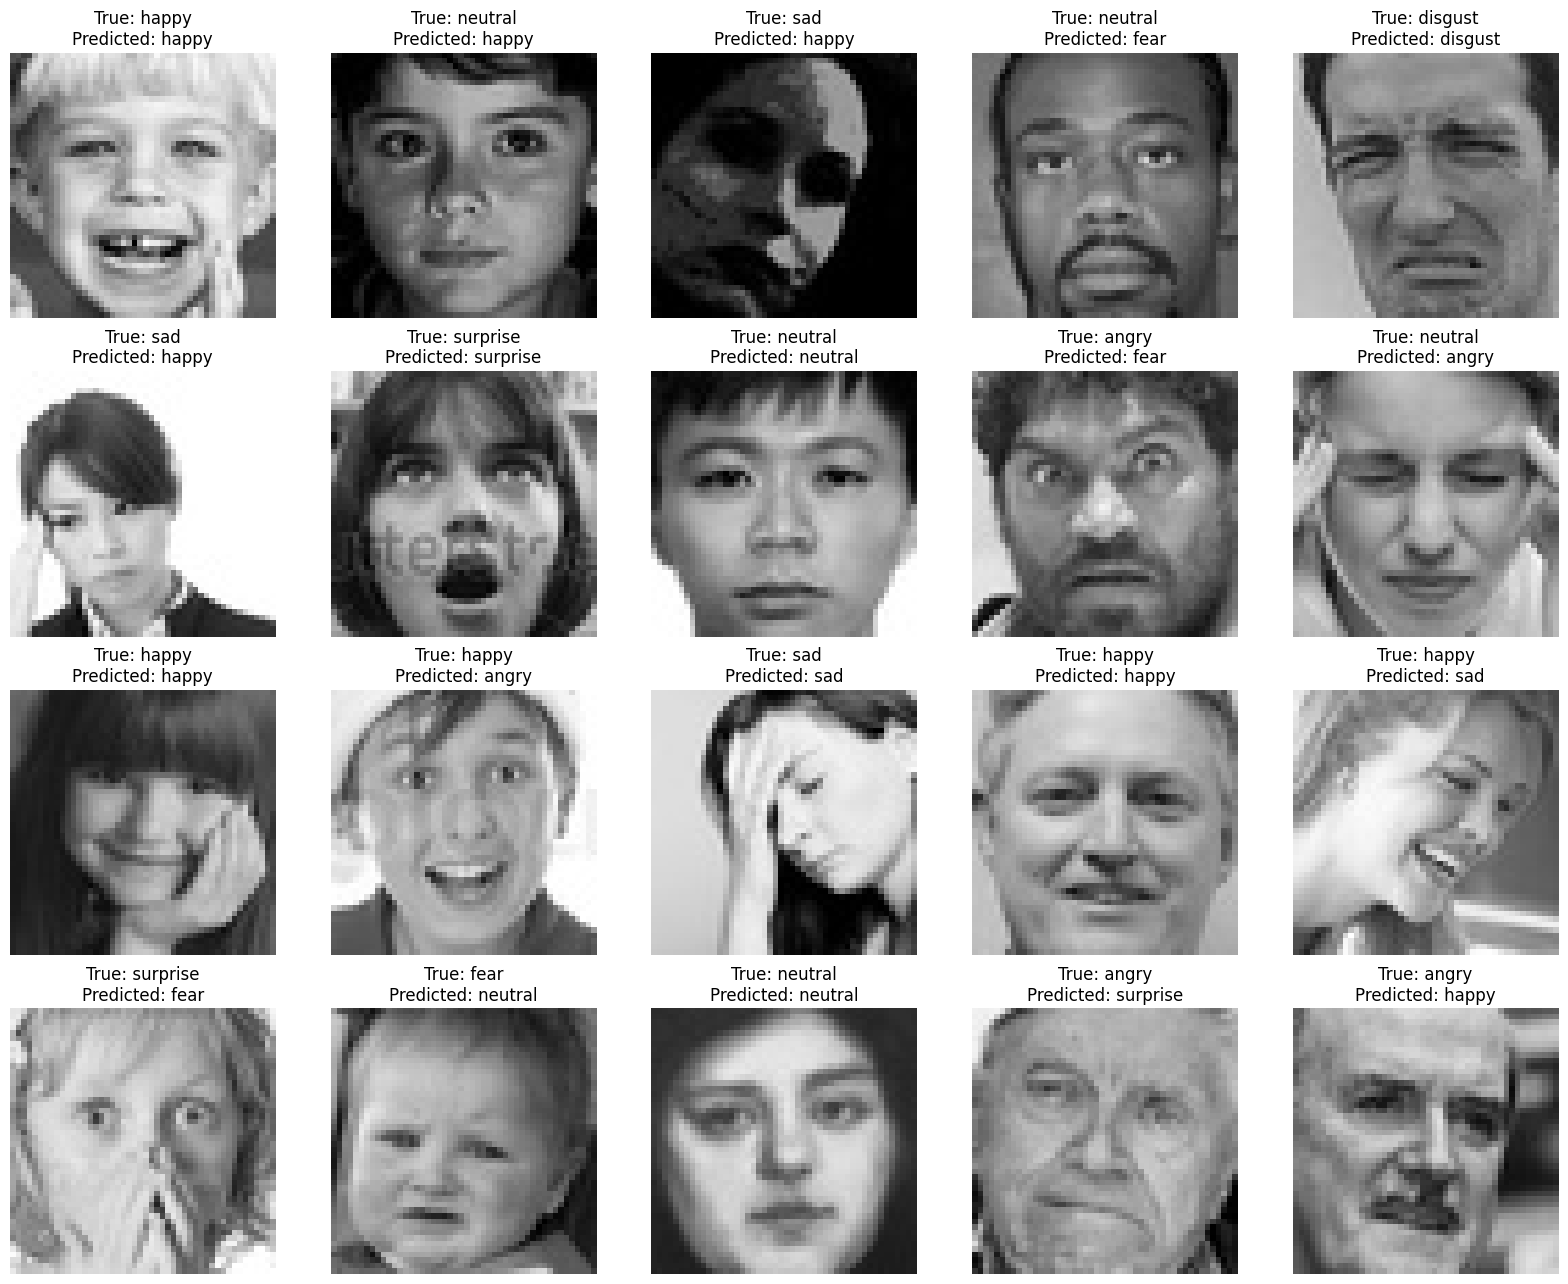

In [25]:
plt.figure(figsize=(20, 20))
j = 1
for i in range(21,41):
    plt.subplot(5,5,j)
    j=j+1
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(labels[i], class_indexes)
    predicted_label = compute_label(model_1.predict(images[i].reshape((1, 48, 48, 3))), class_indexes)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 50ms/step


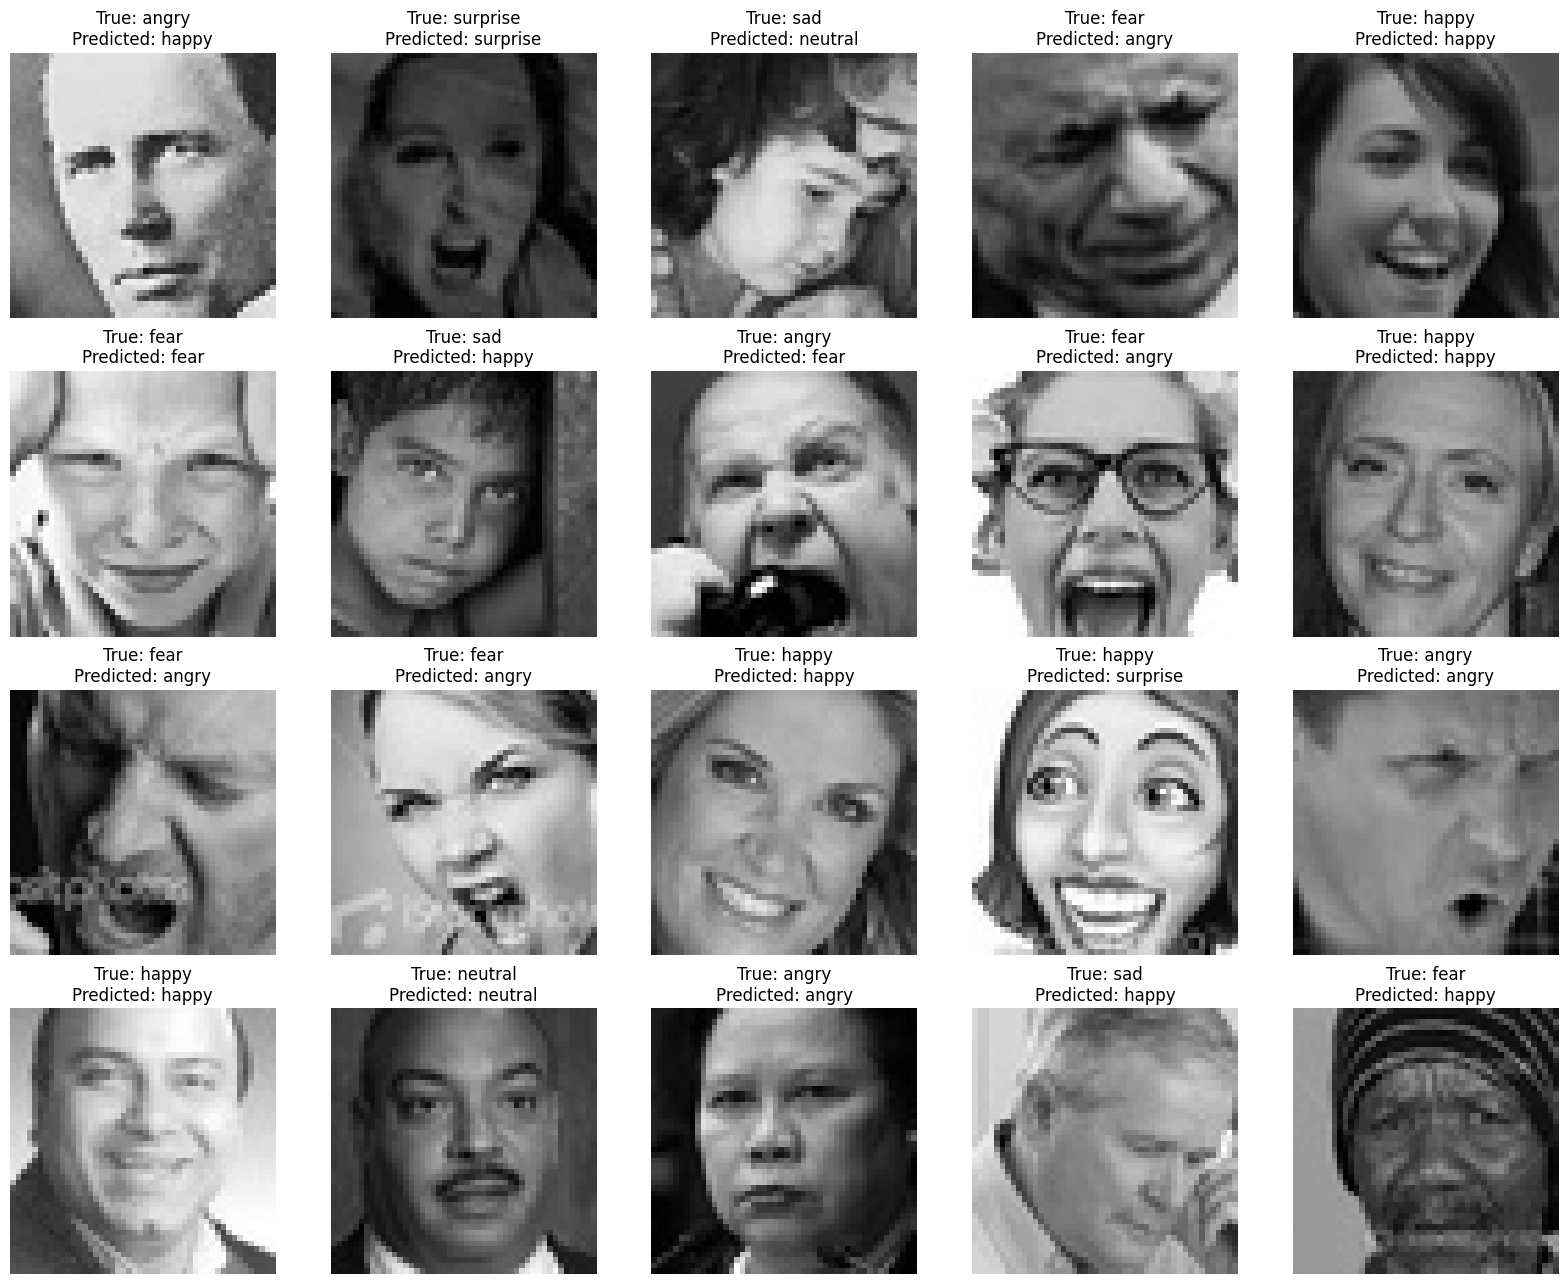

In [26]:
plt.figure(figsize=(20, 20))
j = 1
for i in range(41,61):
    plt.subplot(5,5,j)
    j=j+1
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(labels[i], class_indexes)
    predicted_label = compute_label(model_1.predict(images[i].reshape((1, 48, 48, 3))), class_indexes)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

In [27]:
second_set_images, second_set_labels = next(test_dataset)

1/1 [==============================] - 0s 88ms/step


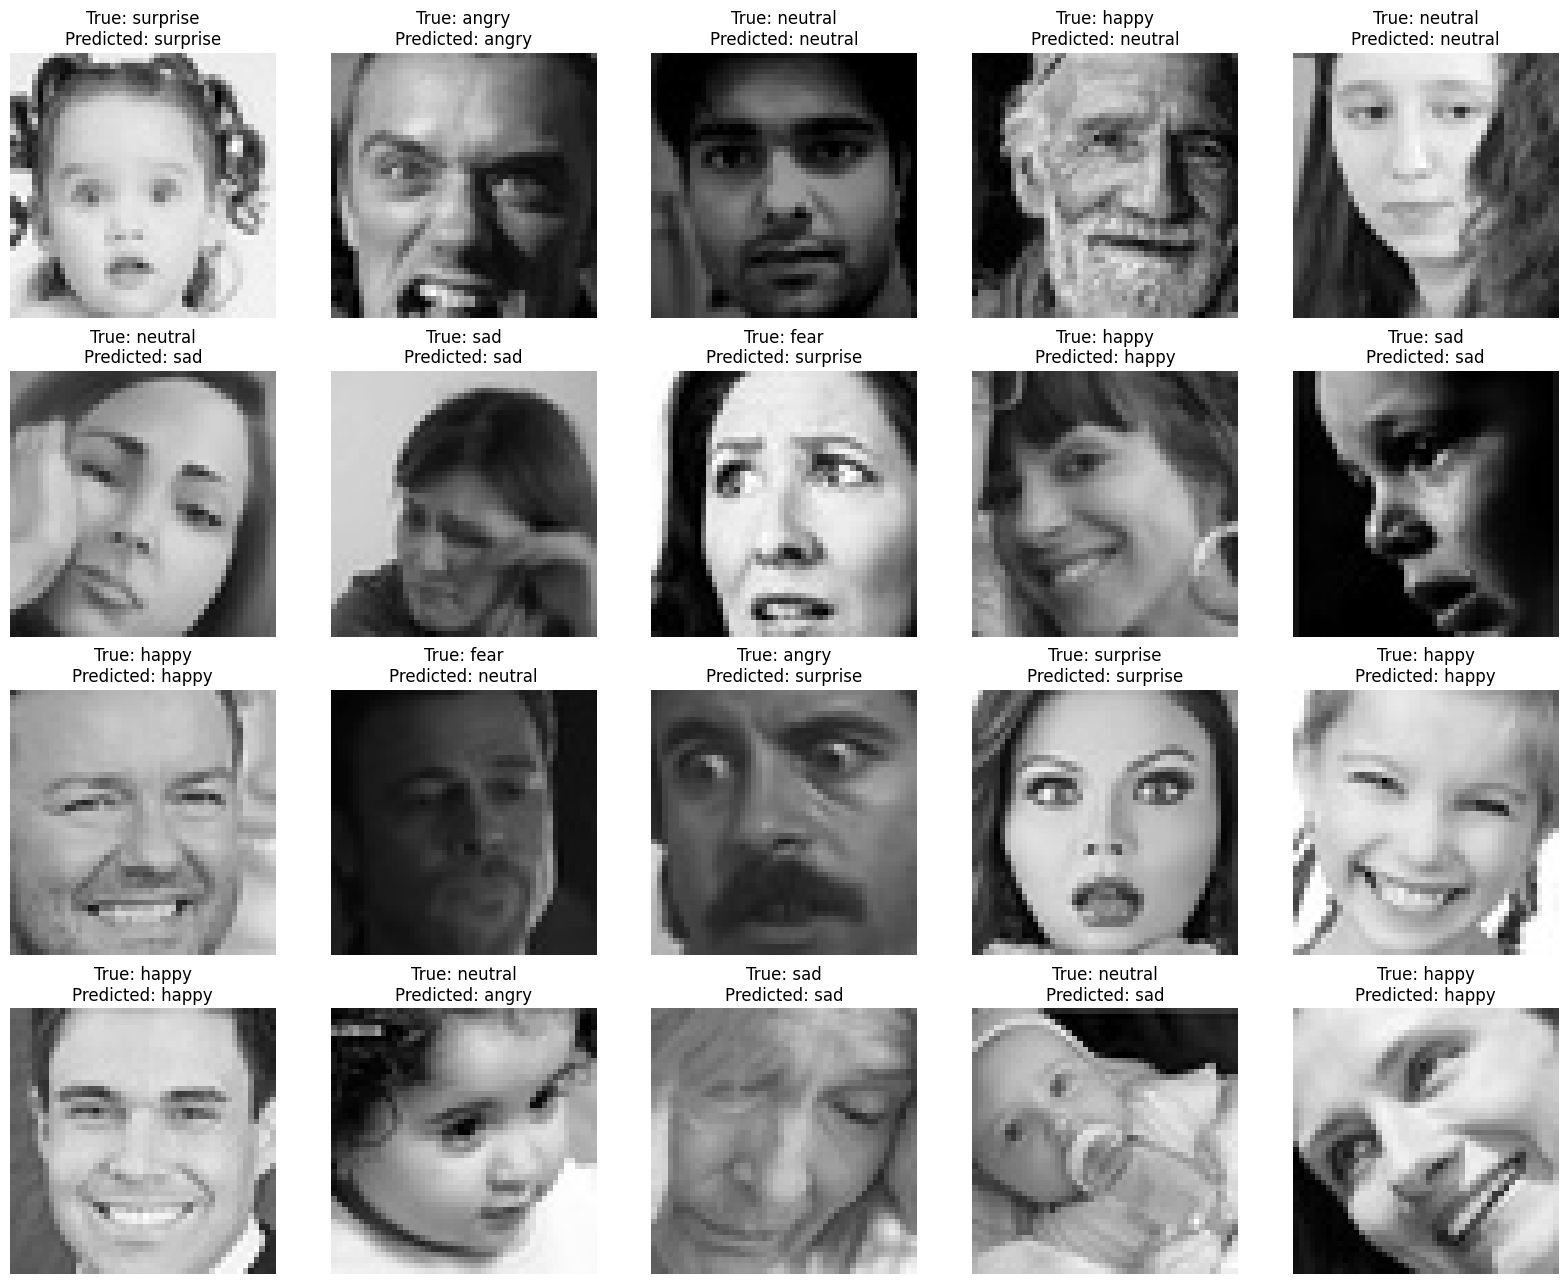

In [28]:
plt.figure(figsize=(20, 20))
j = 1
for i in range(1,21):
    plt.subplot(5,5,j)
    j=j+1
    plt.imshow(second_set_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(second_set_labels[i], class_indexes)
    predicted_label = compute_label(model_1.predict(second_set_images[i].reshape((1, 48, 48, 3))), class_indexes)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 64ms/step


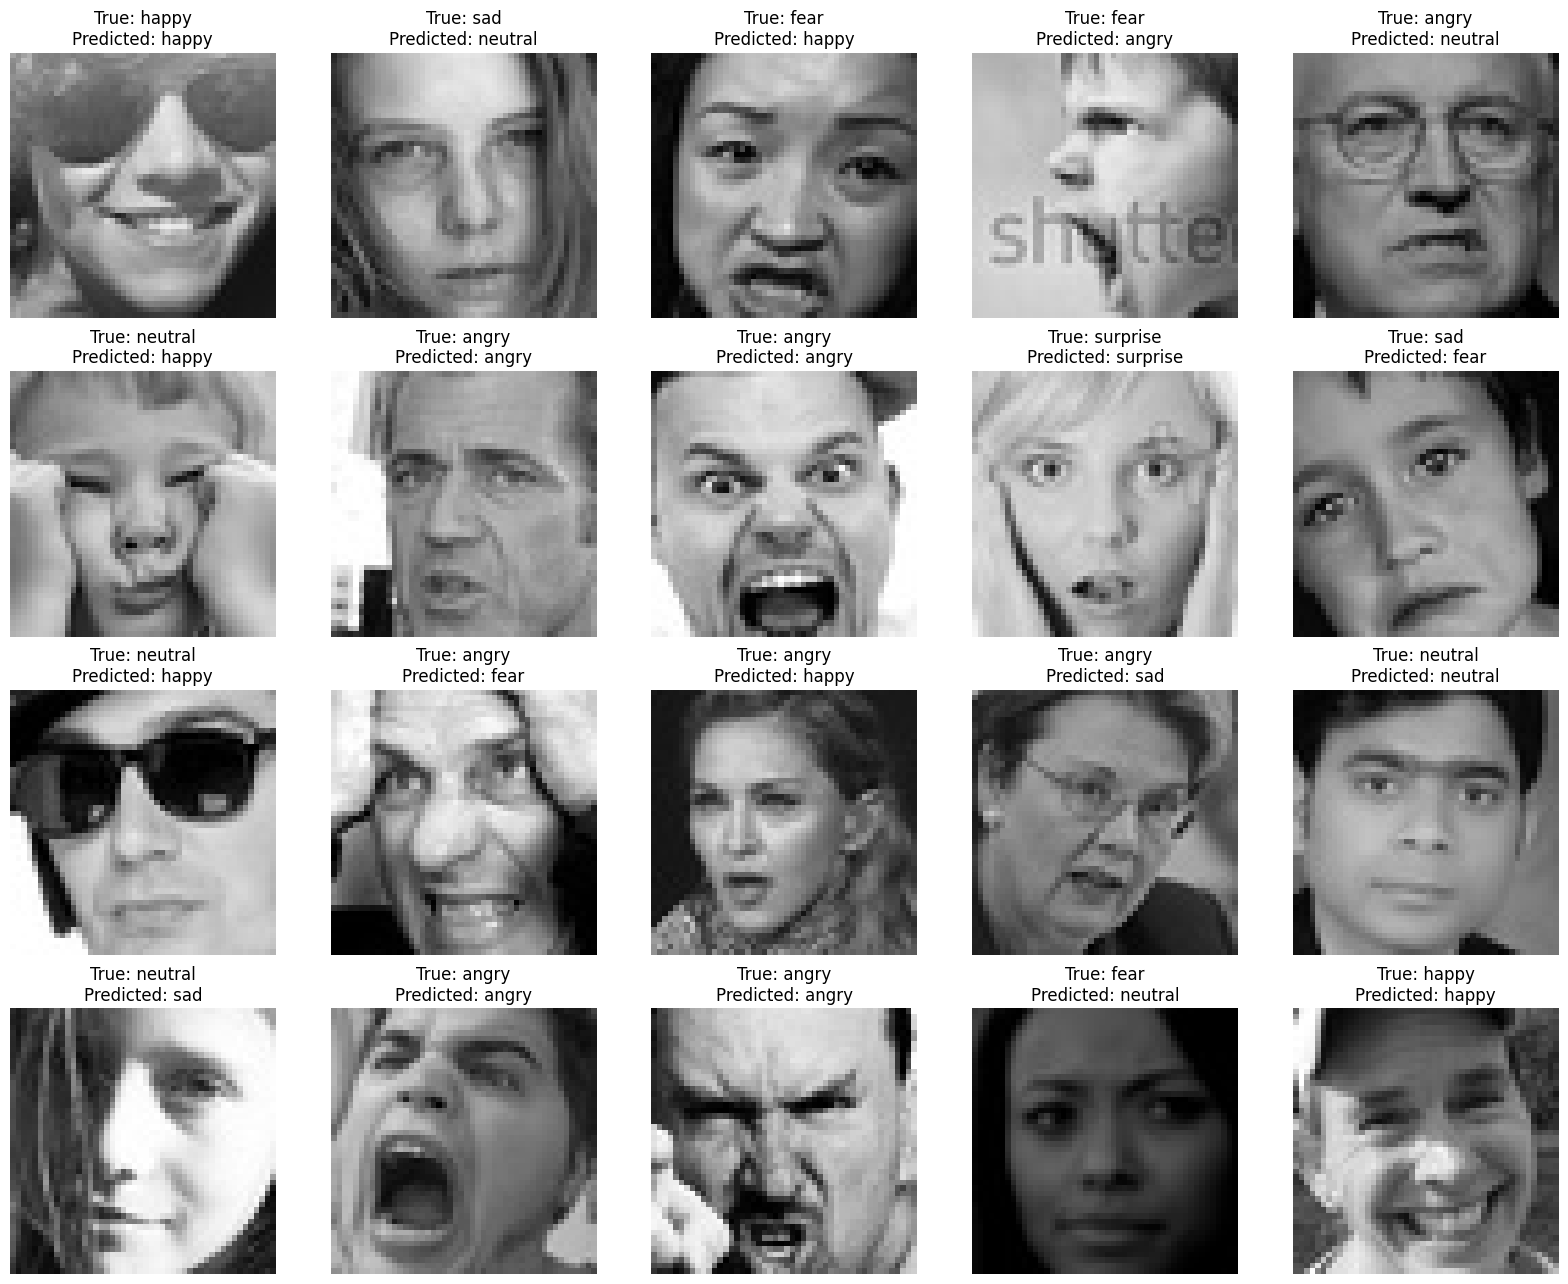

In [29]:
plt.figure(figsize=(20, 20))
j = 1
for i in range(21, 41):
    plt.subplot(5,5,j)
    j=j+1
    plt.imshow(second_set_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(second_set_labels[i], class_indexes)
    predicted_label = compute_label(model_1.predict(second_set_images[i].reshape((1, 48, 48, 3))), class_indexes)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)